In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [31]:
batch_size = 50
epochs = 5
particles = 10
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True
randomization = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 997us/step - loss: 2.3805 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 809us/step - loss: 2.4470 - accuracy: 0.0700
0.07000000029802322
16/16 [==============================] - 0s 1ms/step - loss: 2.3891 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 1ms/step - loss: 2.4278 - accuracy: 0.1240
0.12399999797344208
16/16 [==============================] - 0s 933us/step - loss: 2.4027 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 1ms/step - loss: 2.4314 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 1ms/step - loss: 2.3707 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 1ms/step - loss: 2.5079 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 1ms/step - loss: 2.4219 - accuracy: 0.1140
0.11400000005960464
16/16 [=========================

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization
                new_weights = []
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 115.43089652061462


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 811us/step - loss: 11.8369 - accuracy: 0.0760
0.07599999755620956
16/16 [==============================] - 0s 819us/step - loss: 2.3150 - accuracy: 0.0560
0.0560000017285347
16/16 [==============================] - 0s 875us/step - loss: 68.6218 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 903us/step - loss: 2.8624 - accuracy: 0.0880
0.08799999952316284
16/16 [==============================] - 0s 821us/step - loss: 5.5424 - accuracy: 0.1260
0.12600000202655792
16/16 [==============================] - 0s 748us/step - loss: 96.4961 - accuracy: 0.0600
0.05999999865889549
16/16 [==============================] - 0s 828us/step - loss: 54.9885 - accuracy: 0.0620
0.06199999898672104
16/16 [==============================] - 0s 709us/step - loss: 24.9583 - accuracy: 0.1380
0.1379999965429306
16/16 [==============================] - 0s 782us/step - loss: 38.4925 - accuracy: 0.0680
0.06800000369548798
16/16 [=========

In [18]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x25101ee6b08>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x25101f118c8>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x25101f43988>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x25101f71a08>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x25101fa3a88>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x25102fa3e08>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x25102fdb108>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x25103007488>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x251030397c8>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x251030659c8>}

In [19]:
model_dict["model_1"].get_weights()

[array([[-0.03343892,  0.10579196,  0.08772855, ...,  0.02166912,
         -0.05771473,  0.04410854],
        [ 0.00313494,  0.08328234, -0.0086188 , ...,  0.01102733,
          0.00547253,  0.03753129],
        [-0.00870862, -0.12551028,  0.12021695, ..., -0.06135452,
         -0.06867301, -0.12742831],
        ...,
        [ 0.00275588,  0.1236019 , -0.0676423 , ...,  0.01970494,
          0.01143004, -0.05271605],
        [-0.0396819 ,  0.14198717, -0.1757449 , ..., -0.04084786,
          0.11156743, -0.13791826],
        [ 0.09054514, -0.04808279,  0.04536886, ...,  0.07303305,
          0.01428969, -0.05483482]], dtype=float32),
 array([ 0.09473511,  0.11219341,  0.19383854,  0.08778827,  0.02251657,
         0.01869417, -0.21012491,  0.21551847,  0.05702553,  0.022174  ,
         0.0087953 , -0.11513635, -0.06867213,  0.03949687,  0.06233256,
        -0.0953196 , -0.03185141, -0.00664404,  0.13287112,  0.0584605 ,
         0.16015963, -0.26182312,  0.07667653, -0.07250857,  0.029

In [20]:
y_pred_dict["model_1"]

array([[6.92234099e-01, 1.64032574e-08, 1.10665095e-08, 3.69074587e-05,
        5.08050546e-12, 2.80347678e-07, 1.24189441e-07, 3.07590067e-01,
        2.14472607e-06, 1.36292903e-04],
       [4.56900984e-01, 3.34639958e-06, 7.01075578e-07, 8.00572536e-07,
        1.87569071e-08, 2.01547336e-05, 3.53843427e-10, 2.40430310e-02,
        5.02276778e-01, 1.67542268e-02],
       [9.88111734e-01, 3.36485711e-04, 2.19868380e-03, 5.67432377e-04,
        2.63006328e-08, 1.06995067e-05, 1.71688407e-05, 7.60896644e-03,
        3.14657635e-04, 8.34102568e-04],
       [9.42557514e-01, 8.38580527e-05, 2.22063627e-05, 1.45178242e-03,
        2.80925327e-08, 4.51074056e-02, 9.97527536e-08, 7.17450492e-03,
        3.30665280e-05, 3.56950844e-03],
       [1.68445498e-01, 8.07119824e-04, 1.03237072e-03, 1.47527773e-02,
        2.02987485e-05, 1.03650917e-03, 1.18172058e-04, 4.09171045e-01,
        9.86065716e-02, 3.06009561e-01],
       [3.53276118e-04, 1.94102199e-06, 1.63356155e-08, 2.07519918e-07,
   

In [21]:
jacobian_dict["model_1"]

array([[  -0.       ,   -0.       ,   -0.       ,   -0.       ,
        -200.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,  -45.968075 ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ,   -0.       ,  -79.30865  ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,  -19.95713  ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -9.651897 ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       , -200.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  

In [22]:
train_acc_dict

{'model_1': [0.11500000208616257,
  0.0729999989271164,
  0.09099999815225601,
  0.0860000029206276,
  0.11299999803304672,
  0.12099999934434891,
  0.12200000137090683,
  0.09000000357627869,
  0.1120000034570694,
  0.09799999743700027,
  0.13199999928474426,
  0.12099999934434891,
  0.09200000017881393,
  0.0949999988079071,
  0.09399999678134918,
  0.09600000083446503,
  0.09399999678134918,
  0.07199999690055847,
  0.08100000023841858,
  0.06700000166893005,
  0.08100000023841858,
  0.07900000363588333,
  0.06599999964237213,
  0.08399999886751175,
  0.08399999886751175,
  0.08799999952316284,
  0.10199999809265137,
  0.11500000208616257,
  0.15700000524520874,
  0.09700000286102295,
  0.0860000029206276,
  0.1080000028014183,
  0.08399999886751175,
  0.1080000028014183,
  0.12600000202655792,
  0.15000000596046448,
  0.1080000028014183,
  0.10000000149011612,
  0.16300000250339508,
  0.09200000017881393,
  0.10000000149011612,
  0.164000004529953,
  0.08699999749660492,
  0.093999

In [23]:
test_acc_dict

{'model_1': [0.11400000005960464,
  0.0860000029206276,
  0.07599999755620956,
  0.0860000029206276,
  0.10000000149011612,
  0.11599999666213989,
  0.11800000071525574,
  0.1120000034570694,
  0.12800000607967377,
  0.09399999678134918,
  0.10999999940395355,
  0.07400000095367432,
  0.06599999964237213,
  0.07800000160932541,
  0.0820000022649765,
  0.052000001072883606,
  0.12399999797344208,
  0.08799999952316284,
  0.0860000029206276,
  0.07199999690055847,
  0.09000000357627869,
  0.09600000083446503,
  0.10599999874830246,
  0.08399999886751175,
  0.09799999743700027,
  0.08799999952316284,
  0.10999999940395355,
  0.08799999952316284,
  0.11999999731779099,
  0.07599999755620956,
  0.09399999678134918,
  0.08799999952316284,
  0.07800000160932541,
  0.10999999940395355,
  0.10999999940395355,
  0.13600000739097595,
  0.08799999952316284,
  0.09799999743700027,
  0.1899999976158142,
  0.07400000095367432,
  0.09799999743700027,
  0.19200000166893005,
  0.13600000739097595,
  0.0

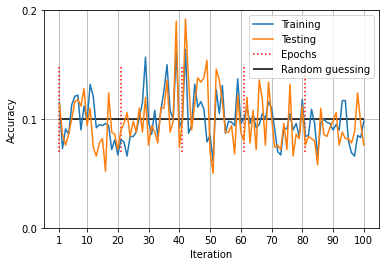

In [24]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

Hier jetzt das Modell mit den gemittelten Gewichten und Bias aus allen Partikel-Modellen.

In [25]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [26]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 811us/step - loss: 2.3165 - accuracy: 0.1120


[2.316476583480835, 0.1120000034570694]

## Wir versuchen das gleiche mit der (falschen?) Jacobi-Matrix aus Tensorflow

In [27]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [28]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [29]:
import tensorflow as tf

loss_fct = tf.keras.losses.CategoricalCrossentropy(reduction = "none")

In [32]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization
                new_weights = []
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights

In [33]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 1ms/step - loss: 7.5041 - accuracy: 0.0740
0.07400000095367432
16/16 [==============================] - 0s 997us/step - loss: 7.8397 - accuracy: 0.0740
0.07400000095367432
16/16 [==============================] - 0s 1ms/step - loss: 531.2853 - accuracy: 0.0840
0.08399999886751175
16/16 [==============================] - 0s 1ms/step - loss: 2.4194 - accuracy: 0.1000
0.10000000149011612
16/16 [==============================] - 0s 1ms/step - loss: 433131.9062 - accuracy: 0.1220
0.12200000137090683
16/16 [==============================] - 0s 873us/step - loss: 2.3138 - accuracy: 0.1000
0.10000000149011612
16/16 [==============================] - 0s 1ms/step - loss: 7.9296 - accuracy: 0.1700
0.17000000178813934
16/16 [==============================] - 0s 1ms/step - loss: 29.1027 - accuracy: 0.1720
0.1720000058412552
16/16 [==============================] - 0s 1ms/step - loss: 34.1056 - accuracy: 0.0660
0.06599999964237213
16/16 [==================

In [34]:
model_dict["model_1"].get_weights()

[array([[ 0.13940845, -0.02821196,  0.06635392, ..., -0.04652647,
          0.06196444, -0.01007827],
        [ 0.12501822,  0.00805927, -0.03798154, ...,  0.01137694,
         -0.06213346, -0.12583524],
        [ 0.01855738, -0.01396389, -0.14162605, ...,  0.0344903 ,
         -0.15421003,  0.18638259],
        ...,
        [-0.22941199, -0.02915054,  0.0593585 , ...,  0.13041264,
         -0.0423886 , -0.0994753 ],
        [-0.0002839 , -0.11052506, -0.02883389, ...,  0.04087816,
         -0.08456451, -0.04488955],
        [ 0.00901606, -0.03482375, -0.08173977, ...,  0.01863994,
         -0.0502822 ,  0.04632675]], dtype=float32),
 array([ 2.25334596e-02,  1.29976749e-01,  9.87607539e-02,  5.47172204e-02,
         6.28615469e-02, -6.66368529e-02,  2.18284391e-02,  1.68720670e-02,
         3.06443423e-02, -1.03113919e-01, -2.33076178e-02,  8.66385102e-02,
        -1.14019655e-01, -2.96185296e-02,  3.36866453e-02, -1.69264413e-02,
         1.00676976e-01, -1.25137240e-01, -4.10579629e

In [35]:
y_pred_dict["model_1"]

array([[9.85214865e-06, 4.78403009e-02, 2.71275931e-04, 6.51355386e-01,
        3.79653298e-04, 4.10328357e-04, 2.96696991e-01, 4.47504775e-04,
        1.24687830e-03, 1.34200731e-03],
       [5.45980299e-07, 2.32671201e-01, 1.02855871e-03, 3.83430362e-01,
        8.67512881e-06, 6.38978032e-04, 3.82121861e-01, 9.00342275e-06,
        8.18736953e-05, 8.95199264e-06],
       [5.27213873e-09, 9.40818310e-01, 1.30446017e-04, 4.66114283e-02,
        5.88040530e-06, 5.32601029e-04, 1.17021082e-02, 1.07356823e-06,
        9.01921812e-05, 1.07958782e-04],
       [2.70769488e-05, 4.43891659e-02, 3.11809526e-05, 1.81411028e-01,
        1.99514325e-05, 1.86237190e-02, 6.76060259e-01, 6.28820504e-04,
        5.66795394e-02, 2.21292786e-02],
       [5.78662048e-06, 2.82662541e-01, 2.40478152e-03, 2.32481718e-01,
        7.18494412e-04, 1.34872156e-03, 4.72630233e-01, 1.24733034e-03,
        5.55558782e-03, 9.44994448e-04],
       [5.82516577e-07, 2.10526273e-01, 1.33518490e-03, 7.75586426e-01,
   

In [36]:
jacobian_dict["model_1"]

array([[-1.0149970e+05,  9.9999970e-01,  9.9999970e-01,  9.9999970e-01,
         9.9999970e-01,  9.9999970e-01,  9.9999970e-01,  9.9999970e-01,
         9.9999970e-01,  9.9999970e-01],
       [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00,  1.0000000e+00, -1.6169662e+00,  1.0000000e+00,
         1.0000000e+00,  1.0000000e+00],
       [ 9.9999988e-01,  9.9999988e-01, -7.6650063e+03,  9.9999988e-01,
         9.9999988e-01,  9.9999988e-01,  9.9999988e-01,  9.9999988e-01,
         9.9999988e-01,  9.9999988e-01],
       [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00, -4.4189003e+01],
       [ 9.9999994e-01,  9.9999994e-01,  9.9999994e-01,  9.9999994e-01,
         9.9999994e-01,  9.9999994e-01,  9.9999994e-01, -8.0071222e+02,
         9.9999994e-01,  9.9999994e-01],
       [ 1.0000001e+00,  1.0000001e+00,  1.0000001e+00,  1.0000001e+00,
   

In [37]:
train_acc_dict

{'model_1': [0.07900000363588333,
  0.10199999809265137,
  0.10000000149011612,
  0.10300000011920929,
  0.10499999672174454,
  0.10400000214576721,
  0.0989999994635582,
  0.0860000029206276,
  0.11800000071525574,
  0.11800000071525574,
  0.12200000137090683,
  0.10499999672174454,
  0.09700000286102295,
  0.09600000083446503,
  0.09799999743700027,
  0.09399999678134918,
  0.09300000220537186,
  0.10300000011920929,
  0.09000000357627869,
  0.07599999755620956,
  0.1120000034570694,
  0.09099999815225601,
  0.09200000017881393,
  0.0989999994635582,
  0.0989999994635582,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.09300000220537186,
  0.09099999815225601,
  0.10100000351667404,
  0.09200000017881393,
  0.09200000017881393,
  0.0989999994635582,
  0.09200000017881393,
  0.09200000017881393,
  0.09200000017881393,
  0.09

In [38]:
test_acc_dict

{'model_1': [0.09799999743700027,
  0.10999999940395355,
  0.1120000034570694,
  0.1080000028014183,
  0.1120000034570694,
  0.10599999874830246,
  0.1080000028014183,
  0.08799999952316284,
  0.1340000033378601,
  0.1420000046491623,
  0.09399999678134918,
  0.10599999874830246,
  0.08399999886751175,
  0.10400000214576721,
  0.10999999940395355,
  0.08799999952316284,
  0.0860000029206276,
  0.09600000083446503,
  0.0820000022649765,
  0.08799999952316284,
  0.14800000190734863,
  0.09799999743700027,
  0.1080000028014183,
  0.10999999940395355,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.1080000028014183,
  0.10000000149011612,
  0.09799999743700027,
  0.07800000160932541,
  0.10000000149011612,
  0.10000000149011612,
  0.10999999940395355,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.109999999403953

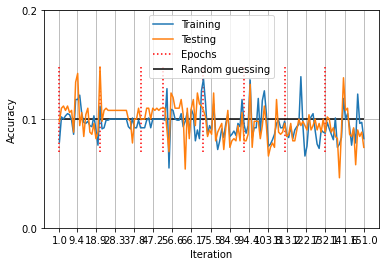

In [50]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

In [49]:
iteration_dict["model_1"]

['Epoch: 1, Batch: 1.',
 'Epoch: 1, Batch: 2.',
 'Epoch: 1, Batch: 3.',
 'Epoch: 1, Batch: 4.',
 'Epoch: 1, Batch: 5.',
 'Epoch: 1, Batch: 6.',
 'Epoch: 1, Batch: 7.',
 'Epoch: 1, Batch: 8.',
 'Epoch: 1, Batch: 9.',
 'Epoch: 1, Batch: 10.',
 'Epoch: 1, Batch: 11.',
 'Epoch: 1, Batch: 12.',
 'Epoch: 1, Batch: 13.',
 'Epoch: 1, Batch: 14.',
 'Epoch: 1, Batch: 15.',
 'Epoch: 1, Batch: 16.',
 'Epoch: 1, Batch: 17.',
 'Epoch: 1, Batch: 18.',
 'Epoch: 1, Batch: 19.',
 'Epoch: 1, Batch: 20.',
 'Epoch: 2, Batch: 1.',
 'Epoch: 2, Batch: 2.',
 'Epoch: 2, Batch: 3.',
 'Epoch: 2, Batch: 4.',
 'Epoch: 2, Batch: 5.',
 'Epoch: 2, Batch: 6.',
 'Epoch: 2, Batch: 7.',
 'Epoch: 2, Batch: 8.',
 'Epoch: 2, Batch: 9.',
 'Epoch: 2, Batch: 10.',
 'Epoch: 2, Batch: 11.',
 'Epoch: 2, Batch: 12.',
 'Epoch: 2, Batch: 13.',
 'Epoch: 2, Batch: 14.',
 'Epoch: 2, Batch: 15.',
 'Epoch: 2, Batch: 16.',
 'Epoch: 2, Batch: 17.',
 'Epoch: 2, Batch: 18.',
 'Epoch: 2, Batch: 19.',
 'Epoch: 2, Batch: 20.',
 'Epoch: 3, Batch:

In [40]:
import tensorflow as tf
initializer = tf.keras.initializers.GlorotNormal()
values = initializer(shape=(2, 2))
values.numpy()

array([[-0.5482841 , -0.41776368],
       [ 0.7376366 , -0.01539072]], dtype=float32)

In [41]:
test = []
h_t = 1
for i in range(len(shapes)):
    
    if shapes[i].shape[0] == 2:
        fan_in = shapes[i][0]
        fan_out = shapes[i][1]
    if shapes[i].shape[0] == 1:
        fan_in = shapes[i-1][0]
        fan_out = shapes[i][0]
    
    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
    noise = np.random.normal(loc = 0.0,
                             scale = stddev,
                             size = tuple(shapes[i]))
    test.append(weights[i] + noise)

In [42]:
np.random.normal(loc = 0.0,
                scale = stddev,
                size = (2, 2))[0]

array([-0.27332713, -0.02210469])

In [43]:
test[0][0]

array([-0.03494312, -0.1001813 , -0.05516722, -0.00778551, -0.02346146,
       -0.00627983,  0.01403356,  0.02648325,  0.00218977,  0.03164814,
        0.03264751,  0.08870243, -0.01827038, -0.08618159,  0.01684424,
        0.06990669, -0.09701331,  0.13380261,  0.01427381, -0.00390245,
       -0.05667372,  0.03124152, -0.02190286, -0.03284651, -0.03297009,
        0.03044899,  0.02578066,  0.03521577, -0.04961607, -0.1053456 ,
        0.10237724,  0.05895514, -0.05879313, -0.06188606,  0.1292802 ,
        0.02683572, -0.10157213,  0.04204414,  0.03476014, -0.05548182,
       -0.00145749, -0.12530557, -0.1851294 ,  0.01434518, -0.0579106 ,
       -0.04681345, -0.12284451,  0.00172349, -0.12114132, -0.02255257,
        0.12963346, -0.0477229 ,  0.01989013, -0.12003153,  0.07041904,
        0.05957276, -0.02080262,  0.06870601,  0.02249137,  0.13815431,
        0.057497  ,  0.06841823, -0.0458134 , -0.00124931,  0.05736764,
        0.04444954,  0.05616156,  0.05677339,  0.08772272,  0.02

In [44]:
weights[0][0]

array([-0.02584926, -0.07543718, -0.02696322, -0.05386816, -0.00882136,
       -0.03388254,  0.02645092,  0.03697884,  0.014042  ,  0.02016344,
       -0.01885175,  0.04661402,  0.0090193 ,  0.0121889 ,  0.00879376,
        0.00797776, -0.09669825,  0.04952619, -0.05392794, -0.00795578,
        0.01784341,  0.02746314, -0.00015725, -0.01241837,  0.05125405,
       -0.01173047,  0.0675158 ,  0.04299703, -0.05876198, -0.05110805,
        0.02640989,  0.01993258, -0.05251456, -0.00657726,  0.05949799,
        0.04970903, -0.05347415,  0.00539832,  0.04007905, -0.0675106 ,
        0.02931323, -0.09562167, -0.07278892, -0.05289871, -0.03444102,
       -0.03032989, -0.05428607,  0.06449173, -0.03546623,  0.00448464,
       -0.00866645, -0.05680899, -0.02645532, -0.0689726 ,  0.00719913,
        0.01036781,  0.04325466,  0.03191362, -0.02262454,  0.04607467,
        0.01055161,  0.05283327,  0.0579607 , -0.02550543,  0.05669101,
        0.04895757,  0.0197274 ,  0.03170567,  0.05043209, -0.06

In [45]:
new = []
for i in range(len(shapes)):
    new.append(weights[i] + test[i])
new

[array([[-0.06079238, -0.17561848, -0.08213043, ...,  0.07030498,
         -0.07807268, -0.00129506],
        [ 0.05144452, -0.02735583,  0.09688325, ...,  0.17800891,
         -0.03116993, -0.17674921],
        [ 0.11049406, -0.09544223, -0.14831975, ..., -0.14223707,
         -0.19843391, -0.07498955],
        ...,
        [-0.01930299,  0.06687351, -0.09516765, ..., -0.1269078 ,
         -0.07943065, -0.00678383],
        [ 0.03622195,  0.10220292, -0.2151133 , ...,  0.27226854,
          0.07123064,  0.03150455],
        [ 0.13929331, -0.11772814, -0.23955339, ..., -0.07531329,
          0.03322912,  0.21227409]]),
 array([-2.18962345e-01,  1.80117123e-01, -2.18070677e-01,  1.65734963e-01,
        -9.41146303e-03,  1.26190768e-01,  3.70316795e-01,  7.75320442e-02,
         1.94855236e-01,  9.43435513e-02,  4.23847456e-03,  1.08657963e-01,
        -1.69333888e-01, -1.64062248e-01,  1.98916100e-02, -1.42811665e-01,
         3.47067304e-02, -1.94406805e-01,  1.88897945e-01, -8.5238091

In [46]:
for i in range(len(shapes)):
    if shapes[i].shape[0] == 2:
        fan_in = shapes[i][0]
        fan_out = shapes[i][1]
    if shapes[i].shape[0] == 1:
        fan_in = shapes[i-1][0]
        fan_out = shapes[i][0]
    print(fan_in)
    print(fan_out)

784
128
784
128
128
128
128
128
128
64
128
64
64
32
64
32
32
10
32
10


In [47]:
shapes

[array([784, 128]),
 array([128]),
 array([128, 128]),
 array([128]),
 array([128,  64]),
 array([64]),
 array([64, 32]),
 array([32]),
 array([32, 10]),
 array([10])]

In [48]:
tuple(shapes[0])

(784, 128)